<a href="https://colab.research.google.com/github/eniktab/heyvane_siamakE/blob/main/tokmi_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, CubicSpline, sproot, splrep
import pandas as pd
import scipy.optimize as opt
import math
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
max_theta = 2 * np.pi
RND = 2
list_t = list(np.arange(0, max_theta, 0.001))

# reading the csv file into a dataframe
col_names = ["x", "y", "z", "MF", "SD", "n"]
df = pd.read_csv("https://raw.githubusercontent.com/eniktab/heyvane_siamakE/main/PM5.csv", sep = ',',  names=col_names, header=None)
# reshape the the df into a matrix
x_index, y_index = dict(), dict()

x_range = np.arange(min(abs(df["x"])), max(abs(df["x"])) + 0.5, 0.5)
y_range = np.arange(min(abs(df["y"])), max(abs(df["y"])) + 0.5, 0.5)

mtx = np.zeros([len(x_range), len(y_range)])

# getting a zero based coordinate center
for _mtx_ind, _x_ind, _y_ind in zip(range(len(x_range)), x_range, y_range):
    x_index[str(_x_ind)] = _mtx_ind
    y_index[str(_y_ind)] = _mtx_ind

# filling the matrix
for _x, _y, _mf in zip(df["x"], df["y"], df["MF"]):
    mtx[y_index[str(abs(_y))], x_index[str(abs(_x))]] = _mf


# finding the x & y center in the stupid way you asked
# OPTION 1: I'm fitting a Gaussian curve and and determine full-with-half-maximum of the peak
# OPTION 2 but you can also use roots of the min/max roots of the derivatives of cubic spline

def gauss(x, H, A, x0, sigma):
    # H is the offset of the gaussian baseline
    # x0 is he center of the gaussian fit
    # sigma the sd
    #  A is amplitude of the gaussian fit so H + A is the maximum intensity of the gaussian
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = opt.curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt


def find_center(mtx, x_range, y_range):
    """
    Fit a cubic spline function and determine full-with-half-maximum of a peaked sets of MF at x and y.
    #TODO It assumes that there is only one peak present in the dataset. Is that correct?
    """
    peak_x = 0
    peak_y = 0
    floor_x = 0
    floor_y = 0
    FWHM_t = 0
    FWHM_fl = 9999
    x_inplt_range = np.linspace(min(x_range), max(x_range), 1000)
    y_inplt_range = np.linspace(min(y_range), max(y_range), 1000)

    for _i in range(mtx.shape[0]):
        # OPTION 1:
        cs = CubicSpline(x_range, mtx[:, _i])
        cd_dr = cs.derivative().roots()
        sigma = max(cd_dr) - min(cd_dr)

        # OPTION 2

        H, A, x0, sigma = gauss_fit(x_inplt_range, cs(x_inplt_range))

        FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma

        if FWHM_t < FWHM:
            FWHM_t = FWHM.tolist()
            peak_x = _i

        if FWHM_fl > FWHM:
            FWHM_fl = FWHM.tolist()
            floor_x = _i

    FWHM_t = 0
    for _j in range(mtx.shape[1]):
        # OPTION 1:
        cs = CubicSpline(y_range, mtx[_j, :])
        cd_dr = cs.derivative().roots()
        sigma = max(cd_dr) - min(cd_dr)

        # OPTION 2
        H, A, x0, sigma = gauss_fit(y_inplt_range, cs(y_inplt_range))

        FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma

        if FWHM_t < FWHM:
            FWHM_t = FWHM
            peak_y = _j

        if FWHM_fl > FWHM:
            FWHM_fl = FWHM.tolist()
            floor_y = _j

    return peak_x, peak_y, floor_x, floor_y

def points_in_circle_np(radius=1, x0=30, y0=-80, rnd=RND):
    x_circle = np.round(np.array([(radius * math.cos(x_y) + x0) for x_y in list_t]), rnd)
    y_circle = np.round(np.array([(radius * math.sin(x_y) + y0) for x_y in list_t]), rnd)
    return x_circle, y_circle


In [ ]:
# draw a circle and get coordinate on its circumference

def points_in_circle_np(radius=1, x0=30, y0=-80, rnd=RND):
    x_circle = np.round(np.array([(radius * math.cos(x_y) + x0) for x_y in list_t]), rnd)
    y_circle = np.round(np.array([(radius * math.sin(x_y) + y0) for x_y in list_t]), rnd)
    return x_circle, y_circle


mfcoor = []
rgrid_x, rgrid_y = np.round(grid_x, RND), np.round(grid_y, RND)
values = {}

for _r in np.arange(0, 16, 0.5):
    values[_r] = []
    x_circle, y_circle = points_in_circle_np(radius=_r, x0=30, y0=-80)
    for _i, _j in zip(x_circle, y_circle):
        if _i in rgrid_x[:, 0] and _j in rgrid_y[0, :]:
            x_coor = np.where(rgrid_x[:, 0] == _i)[0]
            y_coor =  np.where(rgrid_y[0, :] == _j)[0]
            _val = grid_intrplt[x_coor,  y_coor].item(0)
            values[_r].append(_val)
            mfcoor.append([x_coor, y_coor, _val])

In [ ]:
pd.DataFrame.from_dict(values,  orient='index')


,0,1,2,3,4,5,6,7,8,9,...,928,929,930,931,932,933,934,935,936,937
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,0.287555,0.287555,0.287555,0.287555,0.287555,0.287555,0.287555,0.287555,0.287555,0.287555,...,0.287516,0.287516,0.287516,0.287516,0.287516,0.287516,0.287516,0.287516,0.287516,0.287516
1.0,0.286536,0.286536,0.286547,0.286547,0.286547,0.286547,0.286547,0.286547,0.286547,0.286547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.5,0.284395,0.284395,0.284395,0.284395,0.284395,0.284395,0.284411,0.284411,0.284411,0.284411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,0.281826,0.281826,0.281826,0.281826,0.281826,0.281860,0.281860,0.281860,0.281860,0.281860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.5,0.278685,0.278685,0.278685,0.278685,0.278693,0.278693,0.278693,0.278693,0.278699,0.278699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,0.274286,0.274300,0.274300,0.274300,0.274310,0.274310,0.274310,0.274318,0.274318,0.274318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.5,0.267689,0.267689,0.267689,0.267725,0.267725,0.267725,0.267758,0.267758,0.267758,0.267789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,0.260873,0.260873,0.260860,0.260860,0.260860,0.260847,0.260847,0.260836,0.260836,0.260836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.5,0.251286,0.251286,0.251293,0.251293,0.251297,0.251297,0.251298,0.251298,0.251296,0.251296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


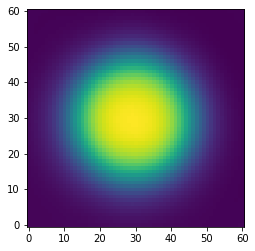

In [ ]:

# sense checking the matrix
plt.imshow(mtx, origin='lower')
plt.show()


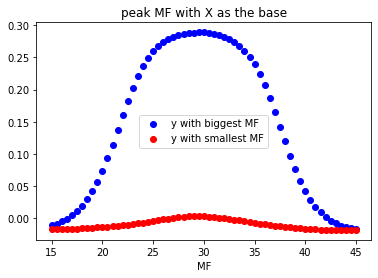

In [ ]:
# sense checking the cubic spline interpolation, and Gaussian fit
plt.title('peak MF with X as the base')
plt.scatter(x_range, mtx[peak_x, :], c="b")
plt.scatter(x_range, mtx[floor_x, :], c="r")
plt.legend(['y with biggest MF', 'y with smallest MF'], loc='best')
plt.xlabel('x')
plt.xlabel('MF')
plt.show()


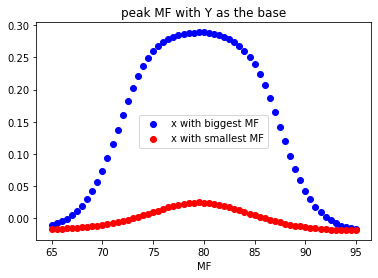

In [ ]:
# sense checking the cubic spline interpolation, and Gaussian fit
plt.title('peak MF with Y as the base')
plt.scatter(y_range, mtx[peak_y, :], c="b")
plt.scatter(y_range, mtx[floor_y, :], c="r")
plt.legend(['x with biggest MF', 'x with smallest MF'], loc='best')
plt.xlabel('y')
plt.xlabel('MF')
plt.show()

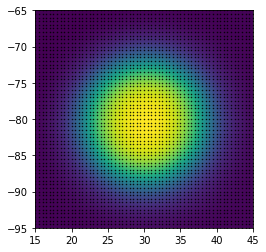

In [ ]:
# sense checking cubic interpolation
plt.plot(data_points[:, 0], data_points[:, 1], 'k.', ms=1)
plt.imshow(grid_intrplt, extent=(minx, maxx, miny, maxy), origin='lower')
plt.show()


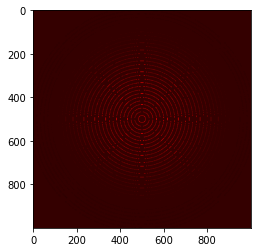

In [ ]:
# sense checking sampling worked 
val_mat = np.zeros([len(rgrid_x), len(rgrid_y)])
for row in mfcoor:
    val_mat[row[0], row[1]] = row[2]


plt.imshow(val_mat, cmap="hot")
plt.show()


